## Описание проекта
Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — **сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?**


### <a href='#Шаг 1'>Шаг №1. Загрузите данные и подготовьте их к анализу</a>

### <a href='#Шаг 2'>Шаг №2. Анализ данных</a>

0. Подготовка данных
1. Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график.
2. Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график.
3. Для какого вида объекта общественного питания характерно сетевое распространение?
4. Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?
5. Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.
6. Выделите в отдельный столбец информацию об улице из столбца address .
7. Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?
8. Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?
9. Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

10. Вывод

## Описание данных
Таблица rest_data:
- **id** — идентификатор объекта;
- **object_name** — название объекта общественного питания;
- **chain** — сетевой ресторан;
- **object_type** — тип объекта общественного питания;
- **address** — адрес;
- **number** — количество посадочных мест.


<a id='Шаг 1'></a>
### Шаг №1. Загрузите данные и подготовьте их к анализу

Установим chart-studio для возможности создания интерактивных графиков

In [1]:
pip install chart-studio==1.0.0

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install cufflinks

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Импортируем необходимые библиотеки

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from pymystem3 import Mystem
m = Mystem()

from io import BytesIO
import requests

pd.options.display.max_colwidth = -1

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from plotly.offline import iplot

import plotly
import cufflinks
cufflinks.go_offline()
import plotly.express as px

Загрузим дата-сэт и посмотрим на данные в нем

In [4]:
rest = pd.read_csv('/datasets/rest_data.csv')
rest.sample(5)

,id,object_name,chain,object_type,address,number
13703,206955,Чайхана Восток,нет,кафе,"город Москва, Новомарьинская улица, дом 14/15",30
1486,157830,Jeffreys coffee,да,кафе,"город Москва, Ладожская улица, дом 8",30
13415,202778,Ташир пицца,да,кафе,"город Москва, Большая Черёмушкинская улица, дом 1",25
7649,70241,Ресторан «Ёрш»,да,ресторан,"город Москва, Липецкая улица, дом 2, корпус 8",120
10805,183073,Пекарня,нет,предприятие быстрого обслуживания,"город Москва, улица Гастелло, дом 44, строение 20",7


Переименуем некоторые столбцы и обратим внимание на типы данных и на пропуски

In [5]:
rest.columns = ['id','name','is_chain','type','address','seats']
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id          15366 non-null int64
name        15366 non-null object
is_chain    15366 non-null object
type        15366 non-null object
address     15366 non-null object
seats       15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


В целом данные корректны, с ними можно работать

Проверим, нет ли дупликатов

In [6]:
rest['id'].duplicated().sum()

0

Проверим тщательнее, вдруг, улицы и названия кафе дублируются с разными регистрами

In [7]:
rest['name_lwr']=rest['name'].str.lower()
rest['address_lwr']=rest['address'].str.lower()
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 8 columns):
id             15366 non-null int64
name           15366 non-null object
is_chain       15366 non-null object
type           15366 non-null object
address        15366 non-null object
seats          15366 non-null int64
name_lwr       15366 non-null object
address_lwr    15366 non-null object
dtypes: int64(2), object(6)
memory usage: 960.5+ KB


In [8]:
rest.duplicated(subset=['name_lwr', 'address_lwr']).sum()

225

Действительно нашли 225 дубликатов, удалим их

In [9]:
rest = rest.drop_duplicates(subset=['name_lwr', 'address_lwr'], keep='first')
rest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15141 entries, 0 to 15364
Data columns (total 8 columns):
id             15141 non-null int64
name           15141 non-null object
is_chain       15141 non-null object
type           15141 non-null object
address        15141 non-null object
seats          15141 non-null int64
name_lwr       15141 non-null object
address_lwr    15141 non-null object
dtypes: int64(2), object(6)
memory usage: 1.0+ MB


Ну и посмотрим на значения средних мер по количеству посадочных мест

In [10]:
rest.seats.describe().round(2)

count    15141.00
mean     59.98   
std      75.04   
min      0.00    
25%      14.00   
50%      40.00   
75%      80.00   
max      1700.00 
Name: seats, dtype: float64

Среднее количество посадочных мест 59,5, медиана - 40 , есть заведения без посадочных мест а также и "выбросы"

### Вывод

- В целом, данные корректны
- Типы данных соответствуют их свойствам
- Блыи переименованы некоторые столбцы
- Дупликатов нет
- Можем наблюдать выбросы в части количества посадочных мест
- Надо будет подумать, как вытягивать название улицы из адреса, так как не всегда адрес начинается с города

<a id='Шаг 2'></a>
### Шаг №2. Анализ данных

#### 0. Подготовка данных

Обработаем поле с адресом для возможности дальнейшего анализа и добавления к нашей таблице данных из внешнего источника. А также, исходя из задания, мы отсекаем из источника данных все заведения из поселений и других городов, несмотря, на то, что формально они относятся к Москве.

In [11]:
#создаем столбец с улицей, если в название есть "город Москва", то берем часть после запятой, есть нет, то часть до запятой
rest = rest.assign(street = lambda x: np.where(x.address.str.contains('город Москва', case=True, regex=True) == True
                                             , x.address.str.split(',').str[1]
                                             , x.address.str.split(',').str[0]))   
#убираем первые и последние пробелы 
rest['street'] = rest['street'].str.strip()

#если после очистки адрес все еще содержит "город" или "поселение", то убираем эти данные (это не улицы)
rest = rest.query('~(street.str.contains("город ") or street.str.contains("поселение "))')
rest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14325 entries, 0 to 15362
Data columns (total 9 columns):
id             14325 non-null int64
name           14325 non-null object
is_chain       14325 non-null object
type           14325 non-null object
address        14325 non-null object
seats          14325 non-null int64
name_lwr       14325 non-null object
address_lwr    14325 non-null object
street         14325 non-null object
dtypes: int64(2), object(7)
memory usage: 1.1+ MB


Создадим классификатор улиц Москвы из внешних источников

In [12]:
#запрос на доступ к файлу на облаке со списком улиц и кодом района
spreadsheet_id = '<17rqkKX8O0I7HXvANKVcD38zTvy7DmsalADfFHnK03vo>'
file_name = 'https://docs.google.com/spreadsheets/d/17rqkKX8O0I7HXvANKVcD38zTvy7DmsalADfFHnK03vo/export?format = xls'\
.format(spreadsheet_id)
r = requests.get(file_name)
streets = pd.read_excel(BytesIO(r.content))


#запрос на доступ к файлу на облаке со списком районов и округов
spreadsheet_id = '<11F9p95inV_5GvV8bKsEk76cQgCCekcG9OIz5VXGI_Q4>'
file_name = 'https://docs.google.com/spreadsheets/d/11F9p95inV_5GvV8bKsEk76cQgCCekcG9OIz5VXGI_Q4/export?format = xls'\
.format(spreadsheet_id)
r = requests.get(file_name)
districts = pd.read_excel(BytesIO(r.content))


#удалим повторяющиеся названия улиц, нет смысла оставлять первые или последние, лучше потом обработаем вручную
streets = streets.drop_duplicates(subset=['street'])

#у длинных улиц оставляем принадлежность только к одному району
streets = streets.assign(code = lambda x: np.where(x.code.str.contains(';', case=True, regex=True) == True
                                             , x.code.str.split(';').str[0]
                                             , x.code))
districts = districts.assign(code = lambda x: np.where(x.code.str.contains(';', case=True, regex=True) == True
                                             , x.code.str.split(';').str[0]
                                             , x.code))


#создаем полный справочник улиц с районами, объеденив таблицы по ключу с кодом района
dir = pd.merge(streets,districts, on = 'code')
dir.sample(5)

,street,code,district,county,county_short
3933,7-я Клеверная улица,1204,поселение Краснопахорское,Троицкий административный округ,Тр АО
4086,1-й Железнодорожный переулок,1206,поселение Новофедоровское,Троицкий административный округ,Тр АО
2505,Пречистенская набережная,0109,район Хамовники,Центральный административный округ,ЦАО
1883,Дохтуровский переулок,0805,район Дорогомилово,Западный административный округ,ЗАО
4092,8-й Железнодорожный переулок,1206,поселение Новофедоровское,Троицкий административный округ,Тр АО


Теперь у нас есть классификатор улиц, который мы объеденим с нашими данными по полю улица из адреса

In [13]:
rest = pd.merge(rest,dir,how = 'left', on = 'street')
rest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14325 entries, 0 to 14324
Data columns (total 13 columns):
id              14325 non-null int64
name            14325 non-null object
is_chain        14325 non-null object
type            14325 non-null object
address         14325 non-null object
seats           14325 non-null int64
name_lwr        14325 non-null object
address_lwr     14325 non-null object
street          14325 non-null object
code            14192 non-null object
district        14192 non-null object
county          14192 non-null object
county_short    14192 non-null object
dtypes: int64(2), object(11)
memory usage: 1.5+ MB


Переименуем некоторые типы заведений, чтобы подписи осей графиков выглядели лучше.

In [14]:
rest['type'] = rest['type'].str.replace('предприятие быстрого обслуживания', 'фаст-фуд').str.replace('отдел кулинарии', '').str.strip('()')

Уберем "район" из названия района, для удобства подписи осей графиков

In [15]:
rest['district_short'] = rest['district'].str.replace('район','').str.strip()

#### 1. Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график.

In [16]:
rest.groupby('type')['seats'].count().reset_index()

,type,seats
0,бар,820
1,буфет,546
2,закусочная,315
3,кафе,5626
4,кафетерий,362
5,магазин,250
6,ресторан,2178
7,столовая,2440
8,фаст-фуд,1788


Text(0.5, 1.0, '1.1. Объекты общественного питания по количеству')

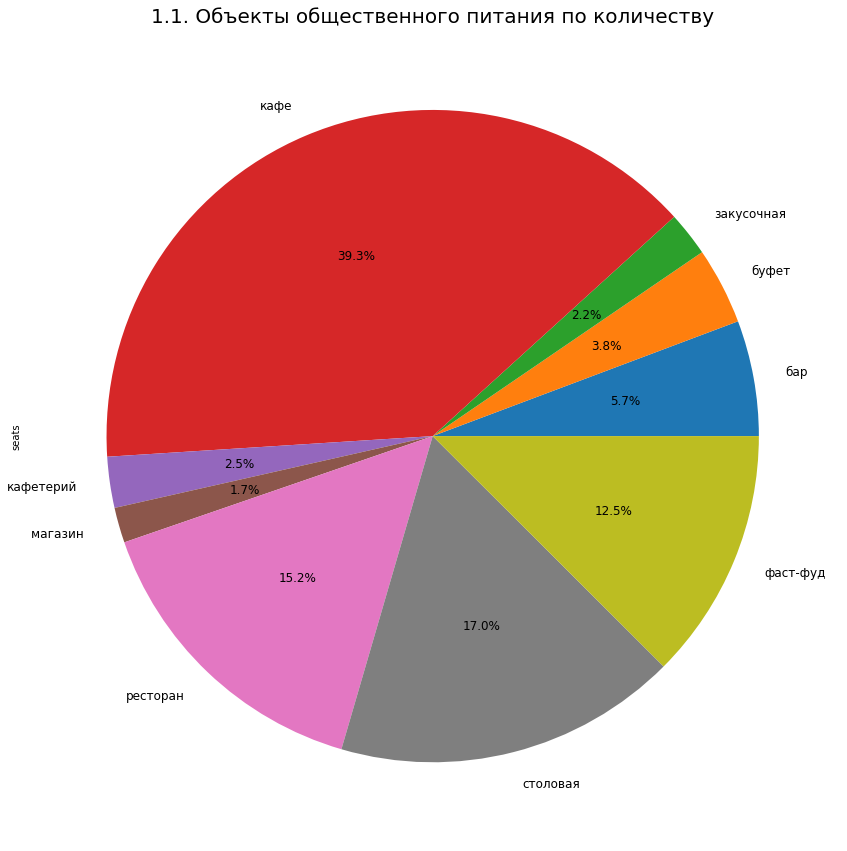

In [17]:
pie1 = rest.groupby('type')['seats'].count().reset_index()
pie1.plot.pie(y = 'seats',
              figsize = (15,15),
              labels=pie1['type'],
              legend = False,
              fontsize=12,
              autopct='%1.1f%%')

plt.title('1.1. Объекты общественного питания по количеству', fontsize=20)

In [18]:
rest.groupby('type')['seats'].count().reset_index().sort_values(by = 'seats', ascending = False)

,type,seats
3,кафе,5626
7,столовая,2440
6,ресторан,2178
8,фаст-фуд,1788
0,бар,820
1,буфет,546
4,кафетерий,362
2,закусочная,315
5,магазин,250


#### Вывод:
Из графика 1.1 видим, что тип заведений "кафе" лидирует большим отрывом ( 5729 заведений в Москве ) это около 40% от всех заведений в Москве.
Надо понимать, что мы будем пытаться охватить самую насыщенную нишу, а значит, конкуренция будет чувствоваться особо сильно.

#### 2. Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график.

Text(0.5, 1.0, '2.1. Cоотношение сетевых и несетевых заведений по количеству')

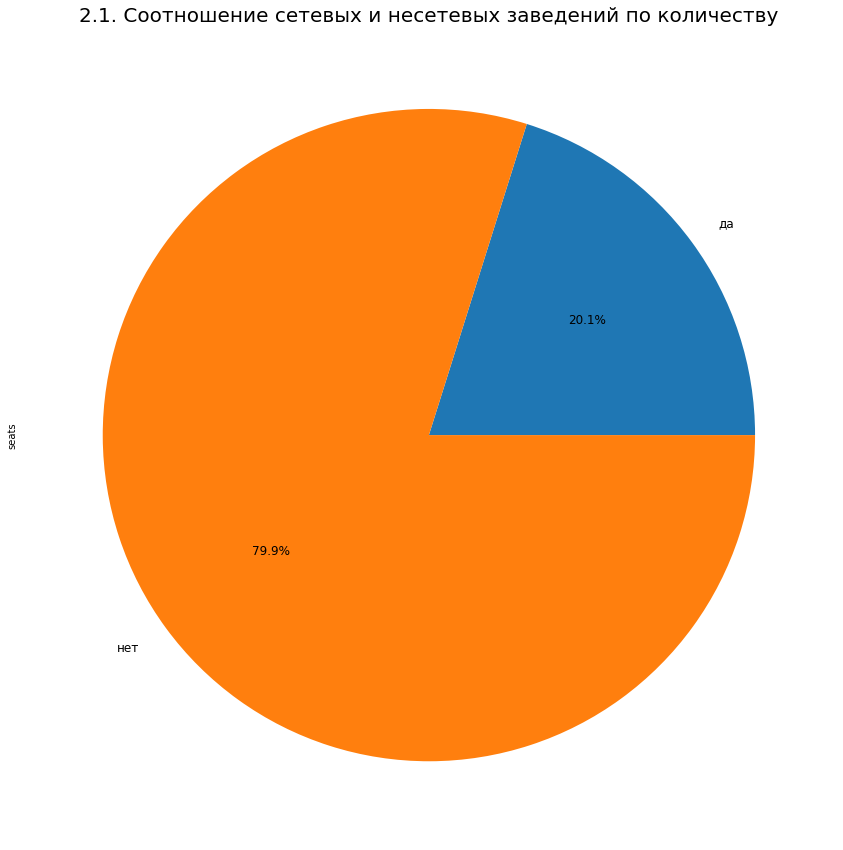

In [42]:
pie2 = rest.groupby('is_chain')['seats'].count().reset_index()
pie2.plot.pie(y = 'seats',
              figsize = (15,15),
              labels=pie2['is_chain'],
              legend = False,
              fontsize=12,
              autopct='%1.1f%%',
              )

plt.title('2.1. Cоотношение сетевых и несетевых заведений по количеству', fontsize=20)

#### Вывод:

- На графике 2.1. видим, что доля сетевых заведений в общем количестве занимает около 20% (2826 шт).


#### 3. Для какого вида объекта общественного питания характерно сетевое распространение?

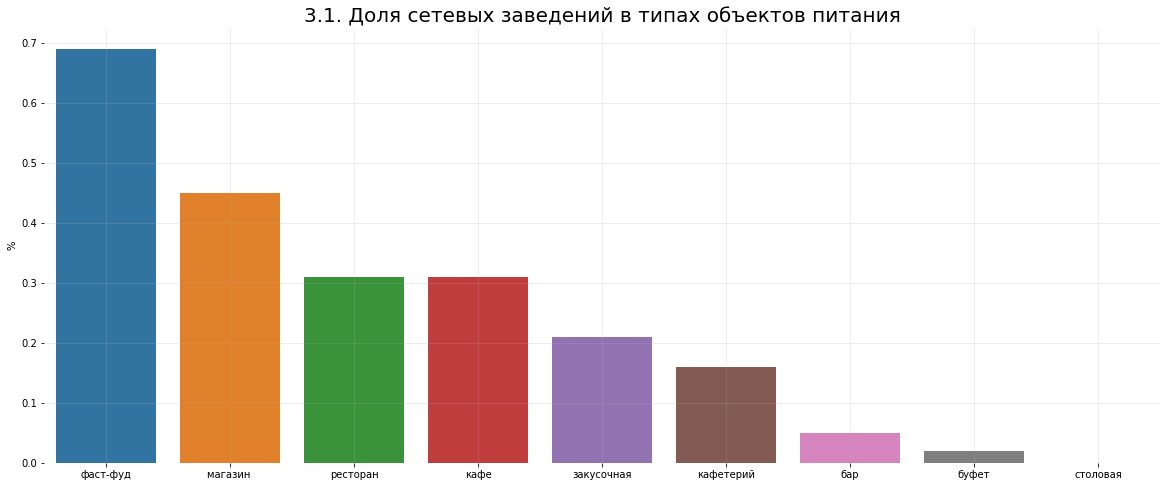

In [22]:
x = chain_grouped_table.groupby('type')['%'].sum().sort_values(ascending = False).T.reset_index()

plt.figure(figsize=(20, 8))
plt.title('3.1. Доля сетевых заведений в типах объектов питания', fontsize=20)
sns.barplot(  x="type"
             , y="%"
             , data=x)
plt.xlabel("")
plt.grid(alpha = 0.25)
sns.despine(left=True, bottom=True)

#### Вывод:

- Сетевые кафе как и рестораны еще не полностью захватили рынок и пока составляют 31%. В то время, как самая большая доля сетевых заведений приходится на фаст-фуд и кулинарию (68% и 44%) - график 3.1.

#### 4. Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Предварительно, для корректного подсчета среднего количества заведений одной сети, необходимо:

1. Убрать выбросы
2. Отфильтровать данные по столбцу со свойством сети
3. Привести все названия к нижнему регистру
4. Так как леммматизация здесь не поможет, то просто удалить названия типов заведений из названий точек.


PS. Я что-то явно делаю не так. раз приходится так много прописывать вариантов вручную, но не нашел другой выход, либюо я плохо перерыл интернет... выручай...


In [23]:
#убираем выбросы
seats_limit  = np.percentile(rest['seats'], 95)
rest = rest.query('seats <= @seats_limit')
rest.info()

#фильтруем только по свойству "сетевое"
chain_rest = rest.query('is_chain =="да"')

#приводим к нижнему регистру
chain_rest['name'] = chain_rest['name'].str.lower()

#отсавляем только название заведения
chain_rest['name'] = chain_rest['name']\
.str.replace('кафе ', '')\
.str.replace('ресторан ', '')\
.str.replace('закусочная ', '')\
.str.replace('кофейня ', '')\
.str.replace('«', '')\
.str.replace('»', '')\
.str.replace('бар ', '')\
.str.replace('пиццерия ', '')\
.str.replace('кальянная ', '')\
.str.replace('предприятие быстрого обслуживания ', '')\
.str.replace('точка продажи готовой ', '')\
.str.replace('бистро ', '')\
.str.replace('пекарня ', '')\
.str.replace('тратория ', '')\
.str.replace('starbucks', 'старбакс')\
.str.replace('vietcafe вьеткафе', 'вьеткафе')\
.str.replace('иль патио il patio', 'иль патио')\
.str.replace('кофешоп coffeeshop company', 'coffeeshop company')\
.str.replace('prime прайм стар', 'прайм стар')\
.str.replace('il forno иль форно', 'иль форно')\
.str.replace('starbucks coffee ', 'старбакс')\
.str.replace('детский клуб ', '')\
.str.replace('кондитерия ', '')\
.str.replace('траттория ', '')\
.str.replace('траттория ', '')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13629 entries, 0 to 14324
Data columns (total 14 columns):
id                13629 non-null int64
name              13629 non-null object
is_chain          13629 non-null object
type              13629 non-null object
address           13629 non-null object
seats             13629 non-null int64
name_lwr          13629 non-null object
address_lwr       13629 non-null object
street            13629 non-null object
code              13505 non-null object
district          13505 non-null object
county            13505 non-null object
county_short      13505 non-null object
district_short    13505 non-null object
dtypes: int64(2), object(12)
memory usage: 1.6+ MB


In [24]:
chain_rest_table = chain_rest.groupby('name').agg({'type': 'count', 'seats': 'sum'}).reset_index()
chain_rest_table.columns = ['name','places','total_seats']
chain_rest_table['avg_seats'] = chain_rest_table['total_seats'] / chain_rest_table['places']
chain_rest_table.describe().round()

,places,total_seats,avg_seats
count,401.0,401.0,401.0
mean,7.0,336.0,53.0
std,19.0,1088.0,42.0
min,1.0,0.0,0.0
25%,1.0,35.0,20.0
50%,1.0,78.0,44.0
75%,4.0,194.0,80.0
max,175.0,12376.0,215.0


Посмотрим, есть ли зависимость между средним количеством мест и количеством заведений в сети

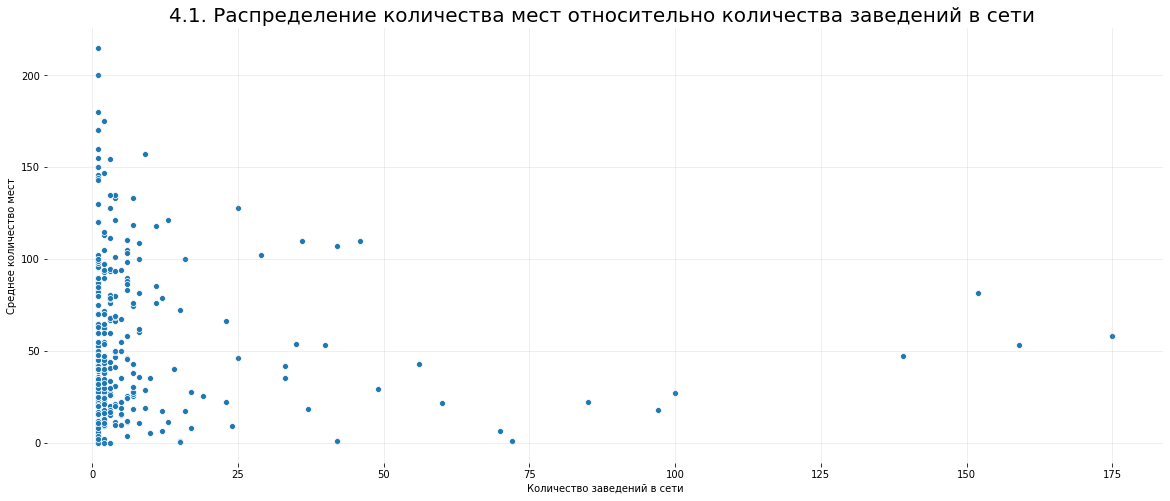

In [25]:
plt.figure(figsize=(20, 8))
plt.title('4.1. Распределение количества мест относительно количества заведений в сети ', fontsize=20)
sns.scatterplot(  x="places"
             , y="avg_seats"
             , data=chain_rest_table)
plt.xlabel("Количество заведений в сети")
plt.ylabel("Среднее количество мест")
plt.grid(alpha = 0.25)
sns.despine(left=True, bottom=True)

Исходя из описательной части и графика можем сделать вывод, что в среднем сетевые заведения имеют несколько (7) точек (берем среднюю, так как может получиться так, что сеть представлена только одной точкой в этом городе, и тогда общая картина о сети исказится) и немного (53) посадочных места.  Но нельзя делать вывод анализируя данные по всему рынку, так как вид заведения очень сильно влияет на цифры, например готовая еда "милти" имеет много точек, но ни одного посадочного места или наоборот, заведение "молли гвинз" всего одно, но целых 250 посадочных мест.

Поэтому для вывода мы отфильтруем данные только по интересующему нас типу заведения "кафе"

In [26]:
chain_cafe = chain_rest.query('type == "кафе"')
chain_cafe = chain_cafe.groupby('name').agg({'type': 'count', 'seats': 'sum'}).reset_index()
chain_cafe.columns = ['name','places','total_seats']
chain_cafe['avg_seats'] = chain_cafe['total_seats'] / chain_cafe['places']
chain_cafe.describe().round()

,places,total_seats,avg_seats
count,259.0,259.0,259.0
mean,5.0,233.0,46.0
std,13.0,701.0,34.0
min,1.0,0.0,0.0
25%,1.0,34.0,20.0
50%,1.0,70.0,38.0
75%,4.0,142.0,67.0
max,168.0,9650.0,220.0


Видим, что ситуация отдельно по кафе немного другая, 5 заведений и 46 посадочных мест

#### Вывод:

Можем сделать вывод, что для сетевых заведений характерно несколько заведений (7) с небольшим числом посадочных мест (53)

#### 5. Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.

Посмотрим на распределение среднего количества посадочных мест по типам заведений

In [27]:
x = rest.pivot_table(index = 'name', columns = 'type', values = 'seats')
x.mean().round(0).sort_values(ascending = False)

type
столовая      100.0
ресторан      80.0 
буфет         47.0 
бар           41.0 
кафе          39.0 
фаст-фуд      14.0 
кафетерий     10.0 
закусочная    9.0  
магазин       7.0  
dtype: float64

Посмотрим график "коробки с усами" чтобы взглянуть и сравнить медианные значения 

In [28]:
rest.pivot_table(  index = 'name'
                 , columns = 'type'
                 , values = 'seats').iplot(kind='box',
                                           title='5.1. Cреднее количество посадочных мест по типам заведений')

#### Вывод:


Видим, что результат был интуитивно понятен:
- в среднем самое большое количество посадочных мест в столовой и ресторанах
- меньше всего посадочных мест в среднем у закусочных, фаст-фудов, магазинов и кафетериях

#### 6. Выделите в отдельный столбец информацию об улице из столбца address .

Был создан в части с подготовкой данных

#### 7. Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

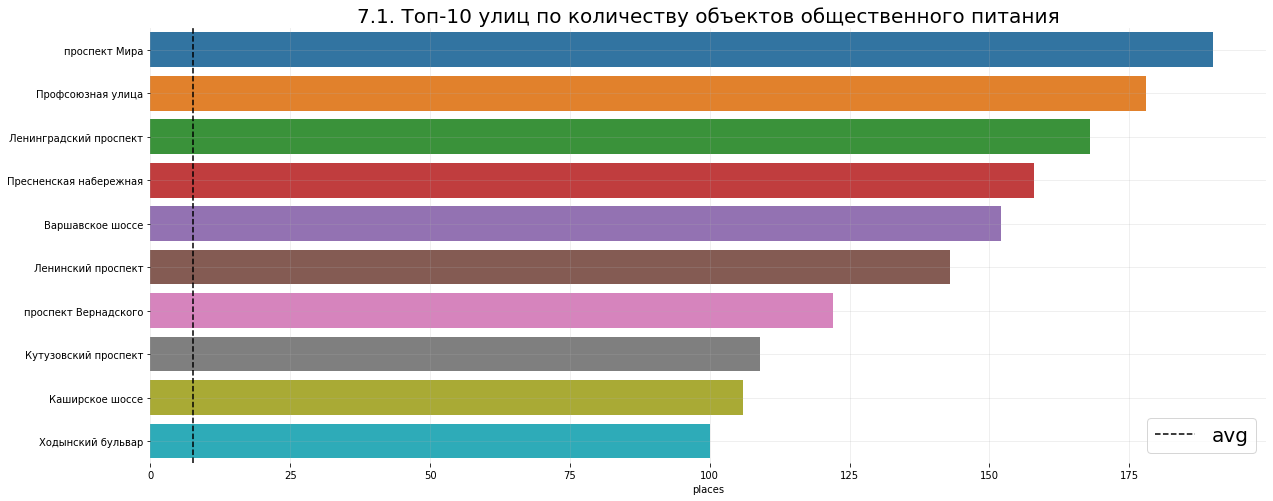

In [29]:
#Группируем заведения по улицам и считаем их количество
rest_top10 = rest.groupby(['street','district_short','county_short'])['name'].count().nlargest(10).reset_index()

#Посчитаем среднее количество заведений на одной улице
street_avg = rest.groupby('street')['name'].count().mean()

#Построим график
plt.figure(figsize=(20, 8))
plt.title('7.1. Топ-10 улиц по количеству объектов общественного питания', fontsize=20)
sns.barplot(  x="name"
             , y="street"
             , data=rest_top10)
plt.ylabel("")
plt.xlabel("places")
plt.grid(alpha = 0.25)
sns.despine(left=True, bottom=True)
plt.axvline(x=street_avg, color='black', linestyle='--', label = 'avg')
plt.legend(fontsize = 20)

In [30]:
rest_top10

,street,district_short,county_short,name
0,проспект Мира,Мещанский,ЦАО,190
1,Профсоюзная улица,Академический,ЮЗАО,178
2,Ленинградский проспект,Аэропорт,САО,168
3,Пресненская набережная,Пресненский,ЦАО,158
4,Варшавское шоссе,Донской,ЮАО,152
5,Ленинский проспект,Якиманка,ЦАО,143
6,проспект Вернадского,Гагаринский,ЮЗАО,122
7,Кутузовский проспект,Дорогомилово,ЗАО,109
8,Каширское шоссе,Москворечье-Сабурово,ЮАО,106
9,Ходынский бульвар,Хорошёвский,САО,100


In [31]:
rest_top10.groupby('county_short')['street'].count().sort_values(ascending = False)

county_short
ЦАО     3
ЮЗАО    2
ЮАО     2
САО     2
ЗАО     1
Name: street, dtype: int64

#### Вывод:

Интересный момент, что количество заведений преобладает не на туристических маршрутах и не на улицах с крупными моллами (хотя есть два представителя в топ-10), а длинные магистрали, но это и логично, что, чем длиннее улица, тем большее население они покрывают, а следовательно, большее количество заведений там могут быть рентабельными. Но плотность заведений будет расти по мере приблежения к центру, так как там выше проходимость


Наибольшее количество улиц из топ 10 в ЦАО - (проспект Мира, Ленинский проспект, Пресненская набережная) 

#### 8. Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [32]:
outcast = rest.groupby(['street','district_short','county_short'])['name'].count().reset_index().query('name == 1')
outcast['street'].count()

528

Посмотрим, к каким райноам и округам относятся эти улицы

In [33]:
outcast.groupby('district_short')['street'].count().sort_values(ascending = False)

district_short
Таганский                    27
Басманный                    26
Хамовники                    23
Тверской                     20
Арбат                        18
                             ..
Куркино                      1 
Левобережный                 1 
поселение Новофедоровское    1 
Марфино                      1 
поселение Рязановское        1 
Name: street, Length: 102, dtype: int64

In [34]:
outcast.groupby('county_short')['street'].count().sort_values(ascending = False)

county_short
ЦАО       178
ВАО       69 
СВАО      56 
ЮВАО      52 
САО       50 
ЗАО       44 
ЮЗАО      29 
СЗАО      24 
ЮАО       22 
Нов АО    2  
Тр АО     1  
Зел АО    1  
Name: street, dtype: int64

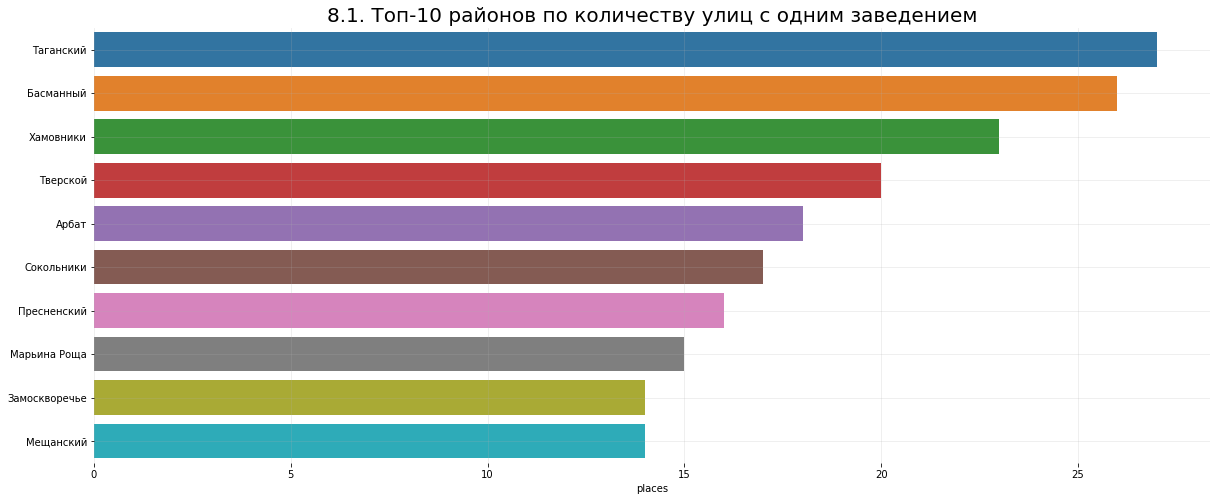

In [35]:
out_districts = outcast.groupby('district_short')['name'].count().nlargest(10).reset_index()

plt.figure(figsize=(20, 8))
plt.title('8.1. Топ-10 районов по количеству улиц с одним заведением', fontsize=20)
sns.barplot(  x="name"
             , y="district_short"
             , data=out_districts)
plt.ylabel("")
plt.xlabel("places")
plt.grid(alpha = 0.25)
sns.despine(left=True, bottom=True)

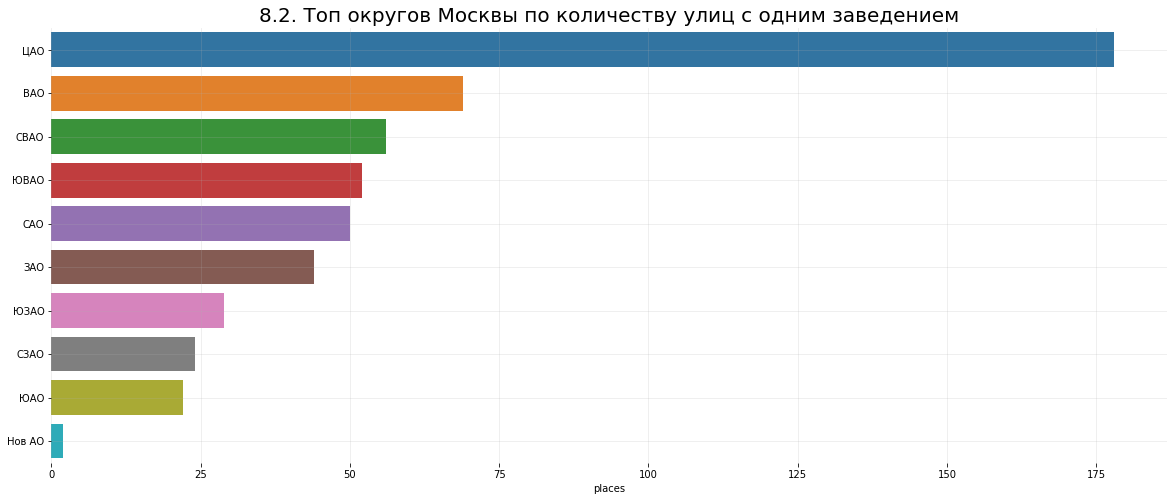

In [36]:
out_countys = outcast.groupby('county_short')['name'].count().nlargest(10).reset_index()

plt.figure(figsize=(20, 8))
plt.title('8.2. Топ округов Москвы по количеству улиц с одним заведением', fontsize=20)
sns.barplot(  x="name"
             , y="county_short"
             , data=out_countys)
plt.ylabel("")
plt.xlabel("places")
plt.grid(alpha = 0.25)
sns.despine(left=True, bottom=True)

In [37]:
dir['district_short'] = dir['district'].str.replace('район','').str.strip()
n_streets = dir.groupby('district_short')['street'].count().reset_index()
districts_grouped = out_districts.merge(n_streets, on = 'district_short')
districts_grouped.columns = ['district_short','streets_one', 'streets_total']
districts_grouped['share'] = (districts_grouped['streets_one'] / districts_grouped['streets_total']).round(2)
districts_grouped

,district_short,streets_one,streets_total,share
0,Таганский,27,164,0.16
1,Басманный,26,150,0.17
2,Хамовники,23,124,0.19
3,Тверской,20,139,0.14
4,Арбат,18,72,0.25
5,Сокольники,17,72,0.24
6,Пресненский,16,129,0.12
7,Марьина Роща,15,46,0.33
8,Замоскворечье,14,83,0.17
9,Мещанский,14,77,0.18


#### Вывод

- Всего в Москве 527 улицы, на которых находится всего один объект общественного питания
- Среди районов Москвы топ3 по количеству улиц с единственным заведением:

    1. Таганский (27 улиц  )
    2. Басманный (26 улиц  )
    3. Хамовники (23 улицы )
    
    
Прежде всего, это связано с большим количеством улиц в этих районах, видим из таблицы выше

- Среди округов с большим отрывом идет ЦАО - 176 улиц с единственным объектом питания
- Ближайший приследователь - только 73 улицы ( ВАО )

Также связано с большим количеством маленьких улиц в центре, в то время, как в отдаленных от центра районах чаще встречаются заведения на центральных улицах / проспектах

#### 9. Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?

In [38]:
rest_top10_table = pd.merge(rest,rest_top10, on= 'street')
rest_top10_pivot = rest_top10_table.pivot_table(index = 'name_x', columns = 'street', values = 'seats')
rest_top10_pivot.iplot(kind='box', title='9.1. Распределение кол-ва мест для улиц с большим количеством объектов')

#### Вывод: 
 - На небольших улицах (пресненская набережная и ходынский бульвар) распределение количества мест чаще решают наличие ТЦ,  в которых много заведений с небольшим количеством посадочных мест, в данном случае (афимолл и авиапарк), на небольших улицах самый нихкий разброс количества мест и медианное значение
 - На шоссе нижний квартиль располагается достаточно низко 7 мест, это говорит, что на шоссе часто можно встретить небольшие закусочные, в которые заезжают быстро перекусить люди за рулем.
 - на длинных улицах (проспекты) - в основном самый большой размах количества мест (в среднем от 20 до 90 ) 

## Общий вывод:

#### Дополнительные расчеты

In [39]:
#Создаем список улиц из ЦАО и только с кафе
cao = rest.query('type == "кафе" & county_short == "ЦАО"')

#Группируем заведения по районам 
cao_list = cao.groupby('district_short')['name'].count().sort_values().reset_index()

#Находим общее количество улиц для каждого района
total_streets = dir.groupby('district_short')['street'].count()
cao_table = cao_list.merge(total_streets, on = 'district_short')

#Находим количество улиц на которых есть хоть одно заведение
occup_cao = cao.groupby('district_short')['street'].nunique().reset_index()
cao_table = cao_table.merge(occup_cao, on = 'district_short')
cao_table.columns = ['district_short','places','total_streets','occupied_streets']

#Находим количество незанятых улиц для каждого района
cao_table['vacant_streets'] = cao_table['total_streets'] - cao_table['occupied_streets']

#находим долю незанятых улиц для каждого района
cao_table['%vacant_streets'] = (cao_table['vacant_streets'] / cao_table['total_streets']).round(2)

#Расчитаем среднее количество кафе на одну улицу для каждого района
cao_table['density'] = (cao_table['places'] / cao_table['total_streets']).round(2)
cao_table.sort_values(by = 'density')

,district_short,places,total_streets,occupied_streets,vacant_streets,%vacant_streets,density
4,Таганский,185,164,49,115,0.70,1.13
0,Красносельский,92,80,22,58,0.72,1.15
2,Хамовники,145,124,41,83,0.67,1.17
1,Якиманка,139,64,22,42,0.66,2.17
6,Тверской,304,139,59,80,0.58,2.19
3,Арбат,171,72,32,40,0.56,2.38
9,Басманный,395,150,51,99,0.66,2.63
8,Пресненский,354,129,58,71,0.55,2.74
5,Замоскворечье,246,83,34,49,0.59,2.96
7,Мещанский,321,77,27,50,0.65,4.17


In [40]:
top_street = cao.query('district_short == "Басманный"')
top_street.groupby('street')['name'].count().nlargest(5)

street
улица Земляной Вал             57
улица Покровка                 43
Нижняя Красносельская улица    42
Мясницкая улица                41
улица Маросейка                36
Name: name, dtype: int64

## Анализ рынка:

#### Количество заведений:

- 40% всех заведений Москвы - кафе 5729 шт. 
- 20% всех заведений - сетевые 2826 шт.

Сетевые кафе как и рестораны еще не полностью захватили рынок и пока составляют 31%.
Доля сетевых заведений составляет в  фаст-фуде и кулинарии 68% и 44%

#### Количество мест:

- В среднем для сетевых заведений характерно несколько заведений - 7 с небольшим числом посадочных мест 53
- Для сетевых кафе - 5 заведений и 46 посадочных мест

В среднем самое большое количество посадочных мест в столовой и ресторанах (100 и 80 мест)
меньше всего посадочных мест в среднем у закусочных, фаст-фудов, магазинов и кафетериях (от 7 до 13 мест)

#### Расположение:

Топ-3 улицы с количеством заведений на них:

1. Проспект Мира - 198 заведений
2. Профсоюзная улица - 178 заведений
3. Ленинградский проспект - 168 заведений

Интересный момент, что количество заведений преобладает не на туристических маршрутах и не на улицах с крупными моллами (хотя есть два представителя в топ-10), а длинные магистрали, но это и логично, что, чем длиннее улица, тем большее население они покрывают, а следовательно, большее количество заведений там могут быть рентабельными. Но плотность заведений будет расти по мере приблежения к центру, так как там выше проходимость

Наибольшее количество улиц из топ 10 в ЦАО - (проспект Мира, Ленинский проспект, Пресненская набережная) 

Топ3 района Москвы количеству улиц с единственным заведением:

    1. Таганский (27 улиц  )
    2. Басманный (25 улиц  )
    3. Хамовники (23 улицы )

Всего в Москве 527 улицы, на которых находится всего один объект общественного питания
    
- Среди округов с большим отрывом идет ЦАО - 178 улиц с едсинственным объектом питания
- Ближайший приследователь - только 73 улицы ( ВАО )

cвязано с большим количеством маленьких улиц в центре, в то время, как в отдаленных от центра районах чаще встречаются заведения на центральных улицах / проспектах

 - На небольших улицах (пресненская набережная и ходынский бульвар) распределение количества мест чаще решают наличие ТЦ,  в которых много заведений с небольшим количеством посадочных мест, в данном случае (афимолл и авиапарк), на небольших улицах самый нихкий разброс количества мест и медианное значение
 - На шоссе нижний квартиль располагается достаточно низко 7 мест, это говорит, что на шоссе часто можно встретить небольшие закусочные, в которые заезжают быстро перекусить люди за рулем.
 - на длинных улицах (проспекты) - в основном самый большой размах количества мест (в среднем от 20 до 90 ) 

## Рекомендации: 


#### 1. Вид заведения: Кафе

Из всех типов заведений, мы рассматриваем только четыре: Фаст-фуд, кафе, ресторан и бар. 
Далее опишем недостатки при выборе каждого из типов заведений:

Фаст-фуд:
 - Очень высокая конкуренция со стороны сетевых заведений (68% заведений фаст-фуда - сетевые, график 3.1.)
 - Планируется, что наше заведение привлекает именно роботами-официантами, что уже неприемлимо для фаст-фуда
 
Ресторан:
- Очень высокий порого входа:
     1. большие инвестиции
     2. необходим огромный опыт управления большим количеством персонала
     3. ценностное предложение ресторана - чаще всего кухня, в нашем случае - это роботы (скорее элемент шоу)    
     
Бар:
- Посетители приходят в бар именно за общением, вряд ли на данный момент робот готов заменить живое человеское общение

Кафе: 
- Из всего вышеперечисленного делаем вывод, что больше всего подходит под наш формат именно кафе

#### 2. Количество посадочных мест: от 20 до 50

- Для кафе свойственно небольшое количество посадочных мест, из анализа рынка завдений Москвы видим, что половина всех заведений имеет от 16 до 50 посадочных мест (график 5.1). 
- Так как мы планируем дорогое заведение и это наше первое заведение, то думаю, следует начать с заведения с количеством мест в этом дипазоне (20-50 мест)


#### 3. Район расположения: ЦАО, районы: Таганский, Красносельский, Хамовники

Мы планируем небольшое заведение, дорогое, с эксклюзивными услугами, нет смысла размещать кафе в спальных районах, пусть даже и густонаселенных (была идея подтянуть население районов к данным), при выборе места акцент должен быть сделан на людном, туристическом месте. Так как ценностное предложение заведения - это роботы официанты, то мы не рассчитываем на высокий retention rate посетителей, больше делаем упор на однократные визиты обеспеченных туристов - наша целевая аудитория. Количество объектов привлекающих туристов больше всего сосредоточено в ЦАО

Районы: выбор районов был сделан на основе загруженности улиц из таблицы во главе вывода. 


#### PS

Разумеется, возможно, это неверный подход - выбирать наименее загруженный район в центре, так как во многих случаях люди будут идти целенаправлено к нам в кафе за нашей уникальной услугой и никакая плотность и наличие конкурентов в непосредственной близости никак не повлияют на посещаемость ... и все наоборот - нам необходимо делать кафе на улице с наибольшим количеством заведений, ведь заведения притягивают людей, а значит поток людей будет выше и может сработать эффект сарафанного радио и слух о нашем кафе будет распространяться быстрее, в таком случае стоит выбирать район Басманный и улицы: улица Земляной Вал, Нижняя Красносельская улица, улица Покровка, Мясницкая улица, улица Маросейка (таблица 2 во главе с выводами)


#### 4. Возможность развития сети:
Стоит посмотреть на работу заведения в течение какого-то времени, если подобный формат хорошо себя зарекомендует, думаю, есть смысл открывавать заведение в другом городе, так как одного подобного заведения на город - уже достачно

#### 5. Общее

Для более детального и тщательного анализа необходимы данные:
- о проходимости и посещаемости заведений на соответсвующих улицах в Москве. Эти данные дают только представления о картине в целом, но их недостаточно, чтобы принимать решения о крупных инвестициях только на их основе 

- бизнес-модель, PL (план), инвестиционный анализ, для понимания необходимого количества посетителей и среднего чека ... хотя-бы.





## Ссылка на презентацию:

https://drive.google.com/file/d/19isep_6L0PcD4MSa-U5W4Fe2D6k5AC4d/view?usp=sharing